# Projet Data Mining : Text classification

Ce projet consiste à analyser les données de Amazon_Video_Games_Review , extraire les caractéristiques textuelles selon plusieurs méthodes et appliquer des modèles de classification afin de retrouver les notes données pour chaque commentaire.

Sommaire général du projet : 

            1  -  Import et analyse exploratoire des données
            2  -  Prétraitement des données :
                    
                    - Stemming
                    - Lemmatisation
                    - Removing stop words

            3 -  Extraction de caractéristiques du texte avec:
                    
                    - TF-IDF               	
                    - Word2Vec
                


            4 -  Modèles de classification
                        
                        - Stochastic Gradient Descent Classifier
                        - KNeighborsClassifier
                        - LogisticRegression
                        - DecisionTree Classifier
                        - LinearSVC
                        - BernoulliNB
                        - MultinomialNB

            5  -  Visualisation
                   
            6  -  Discussion des résultats
            
            7  -  Conclusion et perspectives

# Importing libraires

In [1]:
## for data
import json
import pandas as pd
import numpy as np
import gzip

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk as nlp

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,metrics

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
clear_output(wait=True)

# Transforming the dataset
L'ensemble de données se trouve dans un fichier json, donc on va d'abord le lire dans une liste de dictionnaires avec json, puis le transformer en un pandas Dataframe.

In [2]:
# downloading the dataset

!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz"

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

# transforming the dataset into a dataframe

DS = getDF("./Video_Games_5.json.gz")

--2021-04-19 22:46:02--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  17.0MB/s    in 9.3s    

2021-04-19 22:46:12 (15.8 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]



In [3]:
# display the first five rows of the dataset

DS.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


# Subset of Dataset

In [4]:
df = DS.copy()

# Preprocessing

In [5]:
# delete all columns except overall and review_Text
df.drop(['image','style','vote','reviewerName','verified','reviewTime','reviewerID','asin','summary','unixReviewTime'],inplace=True,axis=1)

# rename these 2 columns
df.rename(columns={"overall": "score", "reviewText": "review" },inplace=True)

# remove duplicates
df.drop_duplicates(inplace=True)

# remove NAN values and duplicates
df.dropna(inplace = True)

# cast score from float to string
df["score"] = df["score"].apply(lambda x: str(int(x)))

## Visualisation of Data

## Word Cloud

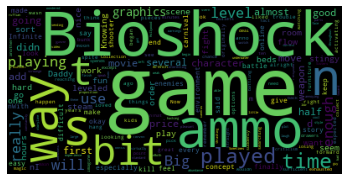

In [6]:
from wordcloud import WordCloud, STOPWORDS

text = DS['reviewText'].values 
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Histogram

In [7]:
categ = list(range(1,6))
frequence = df["score"].value_counts().sort_index().tolist()

Text(0.5, 1.0, 'Distribution des score')

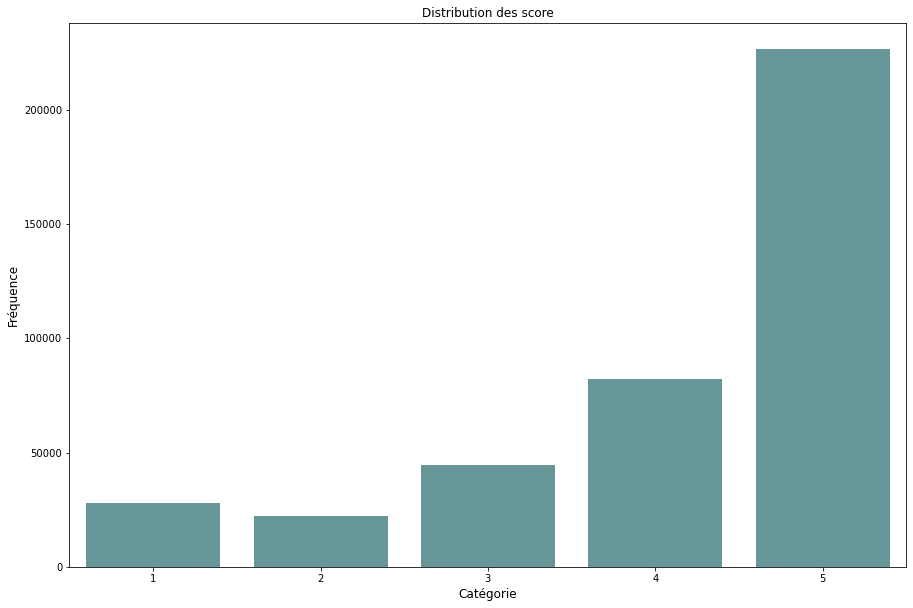

In [8]:
plt.figure(figsize=(15,10))
plt.ylabel('Fréquence', fontsize=12)
plt.xlabel('Catégorie', fontsize=12)
sns.barplot(categ, frequence, color='cadetblue')
plt.title('Distribution des score')

## Classe unbalancing

we noticed a classe unbalance where note 5 is in 70% of the dataset so to avoid that we took same amount of each classe

In [9]:
# due to classes unbalance that tend models to predict a dominant category  
# over the other we decided to take the same amount of data from each category 
# to regularize the generalization of the model

df_1 = df[df['score'] == "1"][:1000]
df_2 = df[df['score'] == "2"][:1000]
df_3 = df[df['score'] == "3"][:1000]
df_4 = df[df['score'] == "4"][:1000]
df_5 = df[df['score'] == "5"][:1000]
x = [df_1, df_2, df_3,df_4,df_5]
df = pd.concat(x)

# Stemming + Lemmarization + removing Stopwords


* Stemming est le processus de réduction de l'inflexion des mots à leur forme racine, comme le mappage d'un groupe de mots sur la même racine, même si la racine elle-même n'est pas un mot valide dans la langue.

* Lemmatisation : contrairement au Stemming, elle réduit correctement les mots fléchis en s'assurant que le mot racine appartient à la langue. Dans la lemmatisation, le mot racine est appelé Lemme. Un lemme est la forme canonique, la forme du mot dans le dictionnaire ou la forme de citation d'un ensemble de mots.

* Stop words: les mots vides sont des mots qui ne contiennent pas de signification importante à utiliser dans les requêtes de recherche. Habituellement, ces mots sont exclus des requêtes de recherche car ils renvoient une grande quantité d'informations inutiles. Chaque langue donne sa propre liste de mots vides à utiliser. voici un exemple des mots vides en la langue anglaise : as, the, be, are, etc.

In [10]:
# preprocessing texts using a function which contains the porter stemmer for stemming 
# and WordNetLemmatizer for lemmatizing

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

i = 0
def preprocess_text(text):
    chars="\n,."
    for char in chars:
        text = text.replace(char," ")
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split()
    lst_stopwords = stopwords.words("english")
    lst_text = [word for word in lst_text if word not in lst_stopwords]
    ps = PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]
    lem = WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
    ############
    clear_output()
    global i
    i+=1
    print(f'{i} / {df.shape[0]}')
    ###############
    text = " ".join(lst_text)
    return text


df["review"] = df["review"].apply(preprocess_text)  

5000 / 5000


## Visualisation after removing classe unbalancing

In [11]:
categorie = list(range(1,6))
freq = df["score"].value_counts().sort_index().tolist()

Text(0.5, 1.0, 'Distribution des score')

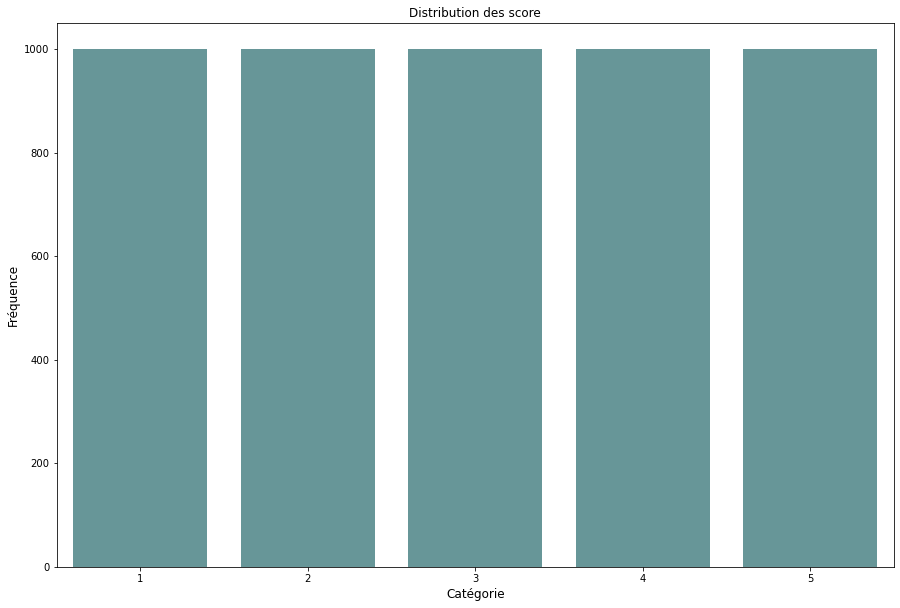

In [12]:
# Visualisation of the categories frequency

plt.figure(figsize=(15,10))
plt.ylabel('Fréquence', fontsize=12)
plt.xlabel('Catégorie', fontsize=12)
sns.barplot(categorie, freq, color='cadetblue')
plt.title('Distribution des score')

# Spliting dataset to train and test

In [13]:
## split dataset : 30 % for test and 70% for training

df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## get target
y_train = df_train["score"].values
y_test = df_test["score"].values

# Feature Extraction Applying TFIDF

Le TF-IDF (en anglais term frequency-inverse document frequency) est une méthode de pondération souvent utilisée en recherche d'information et en particulier dans la fouille de textes. Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus. 
                                   
                                    W(d, t) = TF(d, t) ∗ log( N d f(t) )

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

vectorizer.fit(df["review"])

X_train = vectorizer.transform(df_train["review"])

X_test = vectorizer.transform(df_test["review"])

# Word2Vec

Les modèles en sac de mots a comme Tf-Idf  se concentre juste sur la représentation syntaxique de mots (e.g. “This is good” and “Is this good”ont exactement le même représentation vectorielle).En revanche word embedding comme le word2vec apporte la signification sémantique du mot par exemple  les mots “airplane”, “aeroplane”, “plane”, and “aircraft” sont souvent utilisés dans le même contexte.

In [15]:
corpus = df_train["review"]

## create a list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus,delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus],delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [16]:
## fit w2v
## window = 8 : get 8 words of context
## sg : using skip-gram method

nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

# Machine Learning

we will test few machine learning classifiers 

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

pred = 0

def evaluate_model(classifieur, xtrain, ytrain, xtest, ytest):
    score = []
    for clf in classifieur:
        clf.fit(xtrain, ytrain)
        predicted = clf.predict(xtest)
        acc = accuracy_score(ytest, predicted)*100
        score.append(acc)
        global pred
        pred = predicted
        print('Modèle : %s\n' % clf)
        print('Testing accuracy of %s' % acc,'%')
        print('Testing F1 score: {}'.format(f1_score(ytest, predicted, average='weighted')))   
        print('---------------------------------------------------------------------------\n')
        
    return score


models = [SGDClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), LinearSVC(),BernoulliNB(), MultinomialNB(),LogisticRegression()]
score = evaluate_model(models, X_train, y_train , X_test, y_test)

Modèle : SGDClassifier()

Testing accuracy of 48.66666666666667 %
Testing F1 score: 0.48141142245207386
---------------------------------------------------------------------------

Modèle : KNeighborsClassifier()

Testing accuracy of 21.2 %
Testing F1 score: 0.13036775752071442
---------------------------------------------------------------------------

Modèle : DecisionTreeClassifier()

Testing accuracy of 32.4 %
Testing F1 score: 0.3208103876603003
---------------------------------------------------------------------------

Modèle : LinearSVC()

Testing accuracy of 49.13333333333333 %
Testing F1 score: 0.48573445545027294
---------------------------------------------------------------------------

Modèle : BernoulliNB()

Testing accuracy of 41.4 %
Testing F1 score: 0.383117076776972
---------------------------------------------------------------------------

Modèle : MultinomialNB()

Testing accuracy of 50.73333333333333 %
Testing F1 score: 0.5053139155348172
------------------------

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5')])

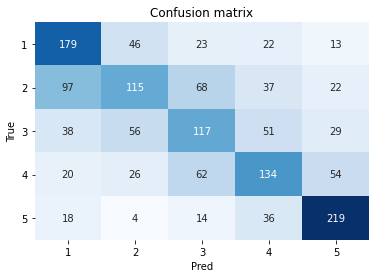

In [18]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=categorie, 
       yticklabels=categorie, title="Confusion matrix")
plt.yticks(rotation=0)

On remarque une confusion entre la catégorie 1 et 2 

# Visualisation

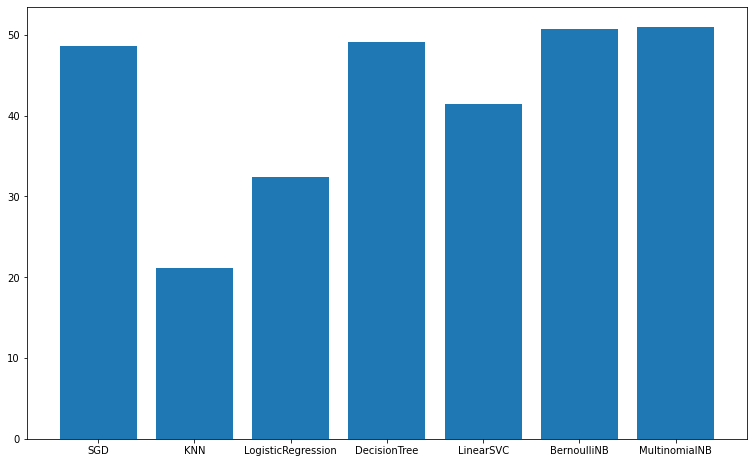

In [19]:
labels = ['SGD', 'KNN', 'LogisticRegression', 'DecisionTree', 'LinearSVC','BernoulliNB', 'MultinomialNB']

fig=plt.figure(figsize=(10,6))
"""
plt.xlabel('classifiers')
plt.ylabel('accuracy')
plt.plot(labels, score)
plt.title('classifiers')
plt.show()
"""
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,score)
plt.show()

# Model selection / GridSearch Hyperparameters

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', vectorizer),
                     ('clf', MultinomialNB()),
                    ])

On souhaiterait utiliser un GridSearch afin de trouver les bon hyperparametre  pour chaque modele et pour quoi pas un cross-validation pour la selection du modéle

In [21]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                'clf__alpha': (1e-2, 1e-3),}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

AttributeError: lower not found

# Results discussion

- En comparent les differentes classifiers, on remarque qu'aucun modele a depasé 60% de precision,peu etre la raison  est l'utilisation d'une partie du jeux de données (pour eviter le probleme du temps d'excution longue) donc les modeles ont pas bien appris a cause de manque de donnée, la 2 eme raison peut etre les parametres par default des classifiers ou les caracteristques des vecteurs (td-idf) qui sont pas pertients , les modeles qui ont donné la meilleure valeur de precision sont Logistic Regression,MultinomialNB,Stochastic Gradient Descent respectivement,le KNN Aa donné la mauvaise precision par rapport aux autre classifieur.

# Conclusion and perspectives

Durant ce projet nous avons pu découvrir le domaine du Naturel Language Processing et le Data mining, on a utilisé toutes les phases d'un projet Machine learning de la préparation des données jusqu'a la prédiction avec le modéle final, On aurait pu utiliser Bert comme méthode d'extraction de données, un modéle puissant se basant sur les transformers, qui représente l'etat de l'art en terme de traitement du langage naturel, faute de temps mais on va quand meme developper ce projet juste pour satisfaire notre curiosité.